In [5]:
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

import shap
import optuna

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

Some useful global constants and setting the seed

In [6]:
SEED = 7
CORR_THRESHOLD = 0.90 
TEST_SIZE = 0.30 # % of the total dataset 
VAL_SIZE = 0.30 # % of the training dataset    
N_TRIALS = 50                     
MAX_PRETRAIN_EPOCHS = 150
MAX_FINETUNE_EPOCHS = 200
EARLY_STOPPING_PATIENCE = 30
BATCH_SIZE = 2048
VIRTUAL_BATCH_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Setting the seed

In [7]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Simple Bootstrapping method to derive the confidence bounds on the AUROC

In [8]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    """ 
    Simple Bootstrapping method to get an confidence interval on the AUROC score.
    """
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

Loading the dataset, pre-processing, and analysing the data

In [9]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,calcium_total_sd,calcium_total_min,calcium_total_max,chloride_mean,chloride_sd,chloride_min,chloride_max,creatinine_mean,creatinine_sd,creatinine_min,creatinine_max,glucose_mean,glucose_sd,glucose_min,glucose_max,hematocrit_mean,hematocrit_sd,hematocrit_min,hematocrit_max,hemoglobin_mean,hemoglobin_sd,hemoglobin_min,hemoglobin_max,mchc_mean,mchc_sd,mchc_min,mchc_max,mch_mean,mch_sd,mch_min,...,pt_mean,pt_sd,pt_min,pt_max,phosphate_mean,phosphate_sd,phosphate_min,phosphate_max,platelet_count_mean,platelet_count_sd,platelet_count_min,platelet_count_max,potassium_mean,potassium_sd,potassium_min,potassium_max,rdw_mean,rdw_sd,rdw_min,rdw_max,red_blood_cells_mean,red_blood_cells_sd,red_blood_cells_min,red_blood_cells_max,sodium_mean,sodium_sd,sodium_min,sodium_max,urea_nitrogen_mean,urea_nitrogen_sd,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,0.292770,7.5,8.3,108.125000,2.356602,105.0,111.0,0.757143,0.113389,0.7,1.0,108.250000,26.596187,81.0,159.0,31.077778,1.943436,28.5,35.0,10.283333,0.421505,9.6,10.8,33.483333,0.711102,32.8,34.8,30.233333,0.524087,29.6,...,14.540000,2.440901,12.7,18.8,3.312500,0.820170,2.5,4.7,118.857143,6.568322,109.0,126.0,3.587500,0.356320,3.1,4.2,14.583333,0.278687,14.1,14.9,3.403333,0.141657,3.17,3.57,143.125000,1.246423,141.0,145.0,15.571429,4.577377,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,NaN,8.9,8.9,102.000000,1.414214,101.0,103.0,0.800000,0.000000,0.8,0.8,225.000000,11.313709,217.0,233.0,37.750000,0.494975,37.4,38.1,13.050000,0.353553,12.8,13.3,34.600000,0.424264,34.3,34.9,26.400000,0.424264,26.1,...,13.700000,NaN,13.7,13.7,2.400000,NaN,2.4,2.4,236.000000,15.556349,225.0,247.0,3.850000,0.070711,3.8,3.9,13.200000,0.141421,13.1,13.3,4.945000,0.049497,4.91,4.98,136.500000,2.121320,135.0,138.0,9.000000,1.414214,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,NaN,8.0,8.0,113.333333,1.527525,112.0,115.0,0.500000,0.000000,0.5,0.5,108.500000,24.748737,91.0,126.0,29.366667,1.888121,26.3,31.2,10.057143,0.704408,9.0,10.7,34.371429,0.309377,34.0,34.7,32.257143,0.723089,31.7,...,14.480000,1.269646,12.9,16.2,2.700000,NaN,2.7,2.7,139.428571,59.642985,75.0,221.0,4.200000,0.294392,3.9,4.6,15.214286,0.445079,14.3,15.6,3.117143,0.194398,2.84,3.32,142.000000,1.414214,141.0,143.0,17.333333,3.214550,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,31.0,31.0,10.400000,NaN,10.4,10.4,33.500000,NaN,33.5,33.5,29.200000,NaN,29.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.000000,NaN,129.0,129.0,NaN,NaN,NaN,NaN,12.700000,NaN,12.7,12.7,3.550000,NaN,3.55,3.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,0.057735,7.7,7.8,111.333333,3.055050,108.0,114.0,0.633333,0.057735,0.6,0.7,110.000000,7.810250,101.0,115.0,33.050000,2.661453,29.8,36.3,11.033333,0.702377,10.3,11.7,33.433333,1.150362,32.3,34.6,30.033333,0.945163,29.3,...,13.066667,0.115470,13.0,13.2,2.450000,0.070711,2.4,2.5,121.000000,8.544004,113.0,130.0,4.000000,0.200000,3.8,4.2,13.300000,0.100000,13.2,13.4,3.690000,0.347707,3.32,4.01,141.333333,3.055050,138.0,144.0,23.000000,1.732051,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [10]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

REmove the ICUstay_id and the gender

In [11]:
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']

Trying out some feature engineering

In [12]:
# X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)
# print(f"initial feature matrix shape: {X.shape}")

# def create_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
#     df_eng = df.copy()
    
#     # BUN/Creatinine ratio (kidney function indicator)
#     if 'urea_nitrogen_mean' in df_eng.columns and 'creatinine_mean' in df_eng.columns:
#         df_eng['bun_creatinine_ratio'] = (
#             df_eng['urea_nitrogen_mean'] / (df_eng['creatinine_mean'] + 1e-6)
#         )

#     # Variability indices (physiological instability)
#     variability_features = []
#     for base_name in ['glucose', 'potassium', 'sodium', 'hemoglobin']:
#         mean_col = f'{base_name}_mean'
#         sd_col = f'{base_name}_sd'
#         if mean_col in df_eng.columns and sd_col in df_eng.columns:
#             cv_col = f'{base_name}_cv'
#             df_eng[cv_col] = df_eng[sd_col] / (df_eng[mean_col] + 1e-6)
#             variability_features.append(cv_col)
    
#     # Range features (max - min)
#     for base_name in ['glucose', 'creatinine', 'potassium']:
#         max_col = f'{base_name}_max'
#         min_col = f'{base_name}_min'
#         if max_col in df_eng.columns and min_col in df_eng.columns:
#             range_col = f'{base_name}_range'
#             df_eng[range_col] = df_eng[max_col] - df_eng[min_col]
    
#     return df_eng

# X_engineered = create_engineered_features(X)
# print(f"final feature matrix shape: {X_engineered.shape}")

Dimensionality reduction by deleting the columns with high correlation.

In [13]:
# corr = X_engineered.corr().abs()
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# to_drop = [col for col in upper.columns if any(upper[col] >= CORR_THRESHOLD)]

# print(f"dropping {len(to_drop)} features")
# X_reduced = X_engineered.drop(columns=to_drop, errors='ignore')
# print(f"final feature count: {X_reduced.shape[1]}")
# feature_names = X_reduced.columns.tolist()

Creating the final train-val-test sets

In [14]:
# separate test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y.values, test_size=TEST_SIZE, random_state=SEED, stratify=y.values)

# separate validation set 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=VAL_SIZE, random_state=SEED, stratify=y_temp)

print(f"Train set: {X_train.shape[0]} samples ({y_train.mean()*100:.2f}% readmission)")
print(f"Validation set: {X_val.shape[0]} samples ({y_val.mean()*100:.2f}% readmission)")
print(f"Test set: {X_test.shape[0]} samples ({y_test.mean()*100:.2f}% readmission)")

# SimpleImputation using median strat and scaling;
# Imputation - FIT on train only and avoidning data leakage:
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Scaling - FIT on train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Train set: 14939 samples (10.74% readmission)
Validation set: 6403 samples (10.74% readmission)
Test set: 9147 samples (10.75% readmission)


Pretraining the TABNet

In [15]:
def run_pretraining(X_train: np.ndarray, X_val: np.ndarray, pretrain_params: dict):
    """Run unsupervised pretraining"""
    pretrainer = TabNetPretrainer(**pretrain_params)
    pretrainer.fit(
        X_train=X_train,
        eval_set=[X_val],
        max_epochs=MAX_PRETRAIN_EPOCHS,
        patience=EARLY_STOPPING_PATIENCE,
        batch_size=BATCH_SIZE,
        virtual_batch_size=VIRTUAL_BATCH_SIZE,
        num_workers=0,
        drop_last=False
    )
    
    print("Pretraining complete!")
    return pretrainer

pretrain_params = dict(
    n_d=32, 
    n_a=32,
    n_steps=5,
    gamma=1.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type="entmax",
    device_name=DEVICE
)

pretrainer = run_pretraining(X_train_scaled, X_val_scaled, pretrain_params)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 12.27619| val_0_unsup_loss_numpy: 3.424139976501465|  0:00:02s
epoch 1  | loss: 11.32026| val_0_unsup_loss_numpy: 3.2746400833129883|  0:00:05s
epoch 2  | loss: 10.2118 | val_0_unsup_loss_numpy: 3.4841198921203613|  0:00:08s
epoch 3  | loss: 9.31887 | val_0_unsup_loss_numpy: 3.6340599060058594|  0:00:11s
epoch 4  | loss: 8.67822 | val_0_unsup_loss_numpy: 3.795259952545166|  0:00:13s
epoch 5  | loss: 8.03425 | val_0_unsup_loss_numpy: 4.024010181427002|  0:00:16s
epoch 6  | loss: 7.4706  | val_0_unsup_loss_numpy: 3.8844199180603027|  0:00:19s
epoch 7  | loss: 6.94101 | val_0_unsup_loss_numpy: 3.1694400310516357|  0:00:21s
epoch 8  | loss: 6.44917 | val_0_unsup_loss_numpy: 3.524480104446411|  0:00:23s
epoch 9  | loss: 6.05784 | val_0_unsup_loss_numpy: 3.4997899532318115|  0:00:26s
epoch 10 | loss: 5.6332  | val_0_unsup_loss_numpy: 3.381969928741455|  0:00:28s
epoch 11 | loss: 5.18665 | val_0_unsup_loss_numpy: 3.610290050506592|  0:00:31s
epoch 12 | loss: 4.89567 | val_0_u

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Hyperparam Search

In [16]:
def make_objective(X_train, y_train, X_val, y_val, pretrainer):
    """Create Optuna objective function"""
    
    def objective(trial):
        # Hyperparameters to tune
        n_d = trial.suggest_int("n_d", 16, 64)
        n_a = trial.suggest_int("n_a", 16, 64)
        n_steps = trial.suggest_int("n_steps", 3, 7)
        gamma = trial.suggest_float("gamma", 1.0, 2.5)
        lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
        
        clf = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,optimizer_params=dict(lr=lr), mask_type=mask_type, device_name=DEVICE, verbose=0)
        
        try:
            clf.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_name=["val"],
                eval_metric=["auc"],
                max_epochs=MAX_FINETUNE_EPOCHS,
                patience=20, 
                batch_size=BATCH_SIZE,
                virtual_batch_size=VIRTUAL_BATCH_SIZE,
                num_workers=0,
                drop_last=False,
                from_unsupervised=pretrainer,
            )
        except Exception as e:
            print(f"Trial failed: {e}")
            raise optuna.exceptions.TrialPruned()
        
        pred_proba = clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, pred_proba)
        
        return auc
    
    return objective

In [17]:
print("hyperparameter optimization under way")
study = optuna.create_study(direction="maximize", study_name="tabnet_readmission_pre-training")

objective = make_objective(X_train_scaled, y_train, X_val_scaled, y_val, pretrainer)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"\nBest trial: {study.best_trial.number}")
print(f"Best validation AUROC: {study.best_value:.4f}")
print("\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

best_params = study.best_trial.params

[I 2025-12-02 12:05:05,027] A new study created in memory with name: tabnet_readmission_pre-training


hyperparameter optimization under way


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 34 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 63 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_auc = 0.64311


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:10:53,364] Trial 0 finished with value: 0.6431101090561354 and parameters: {'n_d': 63, 'n_a': 34, 'n_steps': 5, 'gamma': 2.375848747346354, 'lambda_sparse': 1.0150453098190141e-06, 'lr': 0.002904960572268428, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.6431101090561354.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 51 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 47 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 197 with best_epoch = 177 and best_val_auc = 0.60229


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:21:35,721] Trial 1 finished with value: 0.6022894667236363 and parameters: {'n_d': 47, 'n_a': 51, 'n_steps': 5, 'gamma': 2.130304021726256, 'lambda_sparse': 3.5053839557096555e-06, 'lr': 0.00022236312080409708, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.6431101090561354.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 28 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 63 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 3 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 181 with best_epoch = 161 and best_val_auc = 0.62782


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:30:49,672] Trial 2 finished with value: 0.627819996337667 and parameters: {'n_d': 63, 'n_a': 28, 'n_steps': 3, 'gamma': 1.1100820844802823, 'lambda_sparse': 1.8325402726658204e-06, 'lr': 0.00027967714076842907, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.6431101090561354.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 55 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 45 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 3 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 109 with best_epoch = 89 and best_val_auc = 0.58552


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:35:22,987] Trial 3 finished with value: 0.5855162363425502 and parameters: {'n_d': 45, 'n_a': 55, 'n_steps': 3, 'gamma': 2.468044856500515, 'lambda_sparse': 0.0004221530882989301, 'lr': 0.0002307724936117588, 'mask_type': 'sparsemax'}. Best is trial 0 with value: 0.6431101090561354.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 53 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 38 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_auc = 0.66519


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:39:43,428] Trial 4 finished with value: 0.6651919418502921 and parameters: {'n_d': 38, 'n_a': 53, 'n_steps': 7, 'gamma': 1.7092058362024638, 'lambda_sparse': 1.0453229347334104e-05, 'lr': 0.003024072683588243, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 43 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 21 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 125 with best_epoch = 105 and best_val_auc = 0.64895


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:45:15,143] Trial 5 finished with value: 0.6489486052615516 and parameters: {'n_d': 21, 'n_a': 43, 'n_steps': 7, 'gamma': 1.6211106232833121, 'lambda_sparse': 2.0833184039093435e-05, 'lr': 0.0011588158426885967, 'mask_type': 'sparsemax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 58 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 41 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


Stop training because you reached max_epochs = 200 with best_epoch = 186 and best_val_auc = 0.62454


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:54:01,117] Trial 6 finished with value: 0.6245367403202507 and parameters: {'n_d': 41, 'n_a': 58, 'n_steps': 5, 'gamma': 1.2901245591897352, 'lambda_sparse': 1.0588537657993355e-06, 'lr': 0.00024584440572235545, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 29 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 58 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_auc = 0.61577


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:57:31,312] Trial 7 finished with value: 0.6157688864473336 and parameters: {'n_d': 58, 'n_a': 29, 'n_steps': 6, 'gamma': 1.6694791124748665, 'lambda_sparse': 0.00035935903695026166, 'lr': 0.0013372042475800915, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 34 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 57 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_auc = 0.48265


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 12:58:39,405] Trial 8 finished with value: 0.48264982502187226 and parameters: {'n_d': 57, 'n_a': 34, 'n_steps': 7, 'gamma': 1.9507505561037557, 'lambda_sparse': 0.0004025592687581807, 'lr': 0.00010855901745571555, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 39 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 72 with best_epoch = 52 and best_val_auc = 0.66298


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:02:21,030] Trial 9 finished with value: 0.662976230442125 and parameters: {'n_d': 18, 'n_a': 39, 'n_steps': 7, 'gamma': 1.2601033601622027, 'lambda_sparse': 5.111425541859793e-06, 'lr': 0.002647042812830149, 'mask_type': 'entmax'}. Best is trial 4 with value: 0.6651919418502921.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 30 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 90 with best_epoch = 70 and best_val_auc = 0.67249


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:06:50,338] Trial 10 finished with value: 0.6724902846446521 and parameters: {'n_d': 30, 'n_a': 18, 'n_steps': 6, 'gamma': 1.5023570844547356, 'lambda_sparse': 6.99535756778796e-05, 'lr': 0.004537998964557947, 'mask_type': 'entmax'}. Best is trial 10 with value: 0.6724902846446521.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 30 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_auc = 0.676


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:11:35,695] Trial 11 finished with value: 0.6760023093043602 and parameters: {'n_d': 30, 'n_a': 18, 'n_steps': 6, 'gamma': 1.5130510484586674, 'lambda_sparse': 6.447455127160425e-05, 'lr': 0.004899487513462078, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 31 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_auc = 0.67149


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:15:48,380] Trial 12 finished with value: 0.6714942063928055 and parameters: {'n_d': 31, 'n_a': 16, 'n_steps': 6, 'gamma': 1.4343138581141348, 'lambda_sparse': 9.440425749614164e-05, 'lr': 0.004907449261008185, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 28 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_auc = 0.67242


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:21:44,367] Trial 13 finished with value: 0.672418818287249 and parameters: {'n_d': 28, 'n_a': 16, 'n_steps': 6, 'gamma': 1.4729438023327848, 'lambda_sparse': 7.977702901309571e-05, 'lr': 0.004678384981754271, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 23 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 29 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 4 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 60 with best_epoch = 40 and best_val_auc = 0.62234


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:27:03,570] Trial 14 finished with value: 0.6223361614681886 and parameters: {'n_d': 29, 'n_a': 23, 'n_steps': 4, 'gamma': 1.9835249364440657, 'lambda_sparse': 0.00010785144944351071, 'lr': 0.0014657348817296715, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 21 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 34 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 161 with best_epoch = 141 and best_val_auc = 0.66253


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:36:07,794] Trial 15 finished with value: 0.6625287391401656 and parameters: {'n_d': 34, 'n_a': 21, 'n_steps': 6, 'gamma': 1.044688768371709, 'lambda_sparse': 3.6023971795546226e-05, 'lr': 0.0006713516505281632, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 23 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 24 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 4 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 167 with best_epoch = 147 and best_val_auc = 0.62844


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:45:15,022] Trial 16 finished with value: 0.6284433559177196 and parameters: {'n_d': 24, 'n_a': 23, 'n_steps': 4, 'gamma': 1.5134055722071513, 'lambda_sparse': 4.633673587291443e-05, 'lr': 0.00065743648159628, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 47 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 36 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 121 with best_epoch = 101 and best_val_auc = 0.64729


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:51:17,458] Trial 17 finished with value: 0.6472875846914485 and parameters: {'n_d': 36, 'n_a': 47, 'n_steps': 5, 'gamma': 1.890161869583632, 'lambda_sparse': 0.0001708161504103177, 'lr': 0.0020783332402391245, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 27 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 25 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_auc = 0.65013


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:53:53,190] Trial 18 finished with value: 0.6501285631447231 and parameters: {'n_d': 25, 'n_a': 27, 'n_steps': 6, 'gamma': 1.3765344816067695, 'lambda_sparse': 0.0008217652651285677, 'lr': 0.004918785352071182, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 20 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 4 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 69 with best_epoch = 49 and best_val_auc = 0.626


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 13:57:23,908] Trial 19 finished with value: 0.6259956967588353 and parameters: {'n_d': 16, 'n_a': 20, 'n_steps': 4, 'gamma': 1.821535339931367, 'lambda_sparse': 1.6344788208578936e-05, 'lr': 0.0019402734527306357, 'mask_type': 'entmax'}. Best is trial 11 with value: 0.6760023093043602.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 63 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 44 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 137 with best_epoch = 117 and best_val_auc = 0.68017


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:04:09,828] Trial 20 finished with value: 0.6801725365724632 and parameters: {'n_d': 44, 'n_a': 63, 'n_steps': 6, 'gamma': 1.1672990420036071, 'lambda_sparse': 4.974577194504219e-05, 'lr': 0.0009105150667606697, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 62 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 46 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 167 with best_epoch = 147 and best_val_auc = 0.63698


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:12:26,594] Trial 21 finished with value: 0.6369786262182343 and parameters: {'n_d': 46, 'n_a': 62, 'n_steps': 6, 'gamma': 1.156630594894149, 'lambda_sparse': 5.064393787435411e-05, 'lr': 0.0004457169194625112, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 41 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 42 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 105 with best_epoch = 85 and best_val_auc = 0.67137


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:18:06,748] Trial 22 finished with value: 0.6713664062341044 and parameters: {'n_d': 42, 'n_a': 41, 'n_steps': 6, 'gamma': 1.5790947496040921, 'lambda_sparse': 0.00018096658175165966, 'lr': 0.003485365597865224, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 34 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 50 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 151 with best_epoch = 131 and best_val_auc = 0.6532


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:25:53,730] Trial 23 finished with value: 0.6532016165130521 and parameters: {'n_d': 50, 'n_a': 34, 'n_steps': 5, 'gamma': 1.2432762653848164, 'lambda_sparse': 2.3857169165019986e-05, 'lr': 0.0009544123704343237, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 63 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 33 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 100 with best_epoch = 80 and best_val_auc = 0.66393


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:31:53,471] Trial 24 finished with value: 0.6639322519278112 and parameters: {'n_d': 33, 'n_a': 63, 'n_steps': 7, 'gamma': 1.3551632227476924, 'lambda_sparse': 1.0680871877666568e-05, 'lr': 0.0020064147796507517, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 19 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 52 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 155 with best_epoch = 135 and best_val_auc = 0.65873


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:39:31,258] Trial 25 finished with value: 0.6587283057641051 and parameters: {'n_d': 52, 'n_a': 19, 'n_steps': 6, 'gamma': 1.0079148300924476, 'lambda_sparse': 0.00016563362538100107, 'lr': 0.00045677643452259644, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 47 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 38 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_auc = 0.67241


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:43:27,091] Trial 26 finished with value: 0.6724106797696799 and parameters: {'n_d': 38, 'n_a': 47, 'n_steps': 5, 'gamma': 1.190487990869774, 'lambda_sparse': 6.376844280544343e-05, 'lr': 0.0034759824512139766, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 26 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 26 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_auc = 0.49099


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:44:40,359] Trial 27 finished with value: 0.49099269568048176 and parameters: {'n_d': 26, 'n_a': 26, 'n_steps': 6, 'gamma': 1.5216285908112657, 'lambda_sparse': 3.174987125238579e-05, 'lr': 0.00013427995491277955, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 37 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 21 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 129 with best_epoch = 109 and best_val_auc = 0.65044


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:50:49,870] Trial 28 finished with value: 0.6504399886060754 and parameters: {'n_d': 21, 'n_a': 37, 'n_steps': 7, 'gamma': 1.3799881527688103, 'lambda_sparse': 1.3639180287728937e-05, 'lr': 0.000949089552622901, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 31 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_auc = 0.65283


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:54:39,307] Trial 29 finished with value: 0.6528301694846284 and parameters: {'n_d': 31, 'n_a': 32, 'n_steps': 5, 'gamma': 2.2028780599495277, 'lambda_sparse': 6.711053482552086e-06, 'lr': 0.0035814708444553527, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 47 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 35 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_auc = 0.65766


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 14:59:07,507] Trial 30 finished with value: 0.6576565647317342 and parameters: {'n_d': 35, 'n_a': 47, 'n_steps': 6, 'gamma': 1.7286929762348697, 'lambda_sparse': 0.00011947248732540794, 'lr': 0.0024772109717869045, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 28 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 109 with best_epoch = 89 and best_val_auc = 0.66801


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:04:58,045] Trial 31 finished with value: 0.6680110480375999 and parameters: {'n_d': 28, 'n_a': 16, 'n_steps': 6, 'gamma': 1.4847742923529383, 'lambda_sparse': 7.32229055414557e-05, 'lr': 0.0043003618075568165, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 23 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 100 with best_epoch = 80 and best_val_auc = 0.67734


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:09:57,168] Trial 32 finished with value: 0.677343130073857 and parameters: {'n_d': 23, 'n_a': 18, 'n_steps': 6, 'gamma': 1.5889715546151069, 'lambda_sparse': 0.0002575173703580523, 'lr': 0.004072689905554465, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 24 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 22 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 68 with best_epoch = 48 and best_val_auc = 0.63726


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:13:42,495] Trial 33 finished with value: 0.6372611853750839 and parameters: {'n_d': 22, 'n_a': 24, 'n_steps': 5, 'gamma': 1.5929916204486103, 'lambda_sparse': 0.000311094353913765, 'lr': 0.0016066271968668616, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 19 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 19 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 175 with best_epoch = 155 and best_val_auc = 0.67368


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:22:22,473] Trial 34 finished with value: 0.6736777452237076 and parameters: {'n_d': 19, 'n_a': 19, 'n_steps': 7, 'gamma': 1.803400967454952, 'lambda_sparse': 0.00026843061941714676, 'lr': 0.002613428691608741, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 30 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 19 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 76 with best_epoch = 56 and best_val_auc = 0.64381


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:26:14,694] Trial 35 finished with value: 0.6438098944027345 and parameters: {'n_d': 19, 'n_a': 30, 'n_steps': 7, 'gamma': 2.139144591940925, 'lambda_sparse': 0.00024808804253455936, 'lr': 0.0024786370923863296, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 22 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 52 with best_epoch = 32 and best_val_auc = 0.63602


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:28:53,523] Trial 36 finished with value: 0.6360165008443712 and parameters: {'n_d': 16, 'n_a': 22, 'n_steps': 7, 'gamma': 1.789768436690365, 'lambda_sparse': 0.0006708369943366882, 'lr': 0.003430187545686478, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 57 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 23 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 64 with best_epoch = 44 and best_val_auc = 0.63564


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:32:07,280] Trial 37 finished with value: 0.6356376782844005 and parameters: {'n_d': 23, 'n_a': 57, 'n_steps': 7, 'gamma': 2.005477530043302, 'lambda_sparse': 0.0006410737458331425, 'lr': 0.002956470596090286, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 25 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 43 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 138 with best_epoch = 118 and best_val_auc = 0.6276


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:38:59,089] Trial 38 finished with value: 0.6276035626360659 and parameters: {'n_d': 43, 'n_a': 25, 'n_steps': 7, 'gamma': 1.8448414295105249, 'lambda_sparse': 0.00022980080474631153, 'lr': 0.000397443052923884, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 19 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 20 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 3 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_auc = 0.62001


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:43:04,847] Trial 39 finished with value: 0.6200060021567072 and parameters: {'n_d': 20, 'n_a': 19, 'n_steps': 3, 'gamma': 2.3064968876639256, 'lambda_sparse': 0.0004423373769920696, 'lr': 0.001080092372888657, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 60 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 49 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 174 with best_epoch = 154 and best_val_auc = 0.6681


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:51:53,652] Trial 40 finished with value: 0.6681015890455554 and parameters: {'n_d': 49, 'n_a': 60, 'n_steps': 7, 'gamma': 1.6697018177675873, 'lambda_sparse': 0.00014399961120675325, 'lr': 0.0017055349568530027, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 26 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 105 with best_epoch = 85 and best_val_auc = 0.6608


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 15:57:08,219] Trial 41 finished with value: 0.6607977781847036 and parameters: {'n_d': 26, 'n_a': 18, 'n_steps': 6, 'gamma': 1.6263901901818143, 'lambda_sparse': 4.6162599755344614e-05, 'lr': 0.004033858774589813, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 53 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 40 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 121 with best_epoch = 101 and best_val_auc = 0.67045


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:03:08,336] Trial 42 finished with value: 0.6704480253921749 and parameters: {'n_d': 40, 'n_a': 53, 'n_steps': 6, 'gamma': 1.5577852314033878, 'lambda_sparse': 2.3383374981409076e-05, 'lr': 0.00394854941461318, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 31 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 118 with best_epoch = 98 and best_val_auc = 0.66701


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:08:57,799] Trial 43 finished with value: 0.6670064497751734 and parameters: {'n_d': 31, 'n_a': 18, 'n_steps': 6, 'gamma': 1.7278004601577228, 'lambda_sparse': 5.926308428424023e-05, 'lr': 0.0026278103211863765, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 21 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 39 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 94 with best_epoch = 74 and best_val_auc = 0.68017


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:13:37,405] Trial 44 finished with value: 0.6801666870129606 and parameters: {'n_d': 39, 'n_a': 21, 'n_steps': 6, 'gamma': 1.2898204628432126, 'lambda_sparse': 9.975809292013352e-05, 'lr': 0.0030790532930772252, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 29 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 44 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 100 with best_epoch = 80 and best_val_auc = 0.66841


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:18:34,841] Trial 45 finished with value: 0.668408055097764 and parameters: {'n_d': 44, 'n_a': 29, 'n_steps': 5, 'gamma': 1.0892228413929268, 'lambda_sparse': 0.00027890264844216344, 'lr': 0.003012557114454062, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 22 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 39 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 89 with best_epoch = 69 and best_val_auc = 0.66609


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:23:01,576] Trial 46 finished with value: 0.6660912480416692 and parameters: {'n_d': 39, 'n_a': 22, 'n_steps': 7, 'gamma': 1.3104739185321694, 'lambda_sparse': 9.907937778026752e-05, 'lr': 0.0022353282832630827, 'mask_type': 'sparsemax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 21 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 57 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 63 with best_epoch = 43 and best_val_auc = 0.61786


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:26:09,622] Trial 47 finished with value: 0.6178640460640094 and parameters: {'n_d': 57, 'n_a': 21, 'n_steps': 6, 'gamma': 1.4276311867188332, 'lambda_sparse': 0.00048274210198664307, 'lr': 0.0013430785557114672, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 16 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 18 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 7 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_auc = 0.49341


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:27:15,998] Trial 48 finished with value: 0.49341250584955954 and parameters: {'n_d': 18, 'n_a': 16, 'n_steps': 7, 'gamma': 1.201613622418267, 'lambda_sparse': 0.00012214995340311996, 'lr': 0.0001712769131933992, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 25 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 37 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 134 with best_epoch = 114 and best_val_auc = 0.64384


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 16:34:11,682] Trial 49 finished with value: 0.643836598913508 and parameters: {'n_d': 37, 'n_a': 25, 'n_steps': 6, 'gamma': 1.282202998682981, 'lambda_sparse': 0.00019930388432188654, 'lr': 0.0007534391008868536, 'mask_type': 'entmax'}. Best is trial 20 with value: 0.6801725365724632.

Best trial: 20
Best validation AUROC: 0.6802

Best hyperparameters:
  n_d: 44
  n_a: 63
  n_steps: 6
  gamma: 1.1672990420036071
  lambda_sparse: 4.974577194504219e-05
  lr: 0.0009105150667606697
  mask_type: entmax


Retraining using the best params

In [18]:
final_model = TabNetClassifier(n_d=best_params["n_d"], n_a=best_params["n_a"], n_steps=best_params["n_steps"], gamma=best_params["gamma"], lambda_sparse=best_params["lambda_sparse"], optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=best_params["lr"]), mask_type=best_params.get("mask_type", "entmax"), device_name=DEVICE, verbose=1)

final_model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], eval_name=["val"], eval_metric=["auc"], max_epochs=MAX_FINETUNE_EPOCHS, patience=EARLY_STOPPING_PATIENCE, batch_size=BATCH_SIZE, virtual_batch_size=VIRTUAL_BATCH_SIZE, num_workers=0, drop_last=False, from_unsupervised=pretrainer, weights=1)
final_model.save_model("tabnet_readmission_final")
print("Model saved.")

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 63 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 44 to 32
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 6 to 5
  warnings.warn(wrn_msg)
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.57474 | val_auc: 0.4977  |  0:00:03s
epoch 1  | loss: 1.27593 | val_auc: 0.50531 |  0:00:05s
epoch 2  | loss: 1.14839 | val_auc: 0.52333 |  0:00:08s
epoch 3  | loss: 1.03285 | val_auc: 0.54146 |  0:00:11s
epoch 4  | loss: 1.00124 | val_auc: 0.56548 |  0:00:13s
epoch 5  | loss: 0.93183 | val_auc: 0.56732 |  0:00:16s
epoch 6  | loss: 0.90592 | val_auc: 0.57447 |  0:00:18s
epoch 7  | loss: 0.8674  | val_auc: 0.5813  |  0:00:21s
epoch 8  | loss: 0.85808 | val_auc: 0.57672 |  0:00:23s
epoch 9  | loss: 0.8287  | val_auc: 0.58395 |  0:00:26s
epoch 10 | loss: 0.806   | val_auc: 0.59414 |  0:00:29s
epoch 11 | loss: 0.78763 | val_auc: 0.59783 |  0:00:32s
epoch 12 | loss: 0.77595 | val_auc: 0.59934 |  0:00:35s
epoch 13 | loss: 0.76053 | val_auc: 0.60812 |  0:00:39s
epoch 14 | loss: 0.75562 | val_auc: 0.60585 |  0:00:42s
epoch 15 | loss: 0.74391 | val_auc: 0.60896 |  0:00:45s
epoch 16 | loss: 0.73027 | val_auc: 0.61333 |  0:00:48s
epoch 17 | loss: 0.72863 | val_auc: 0.61124 |  0

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at tabnet_readmission_final.zip
Model saved.


Evaluation

In [22]:
# calculate training error
y_train_pred = final_model.predict(X_train_scaled)
train_error = np.mean(y_train_pred != y_train)
print(f"Training error (Vanilla LR): {train_error:.3f}")

# calculate test error
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
test_error = np.mean(y_pred != y_test)
print(f"Test error (Vanilla LR): {test_error:.3f}")

Training error (Vanilla LR): 0.299
Test error (Vanilla LR): 0.335


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      8164
           1       0.18      0.60      0.28       983

    accuracy                           0.67      9147
   macro avg       0.56      0.64      0.53      9147
weighted avg       0.85      0.67      0.73      9147

ROC-AUC: 0.6804
95% CI = [0.6621, 0.6983]


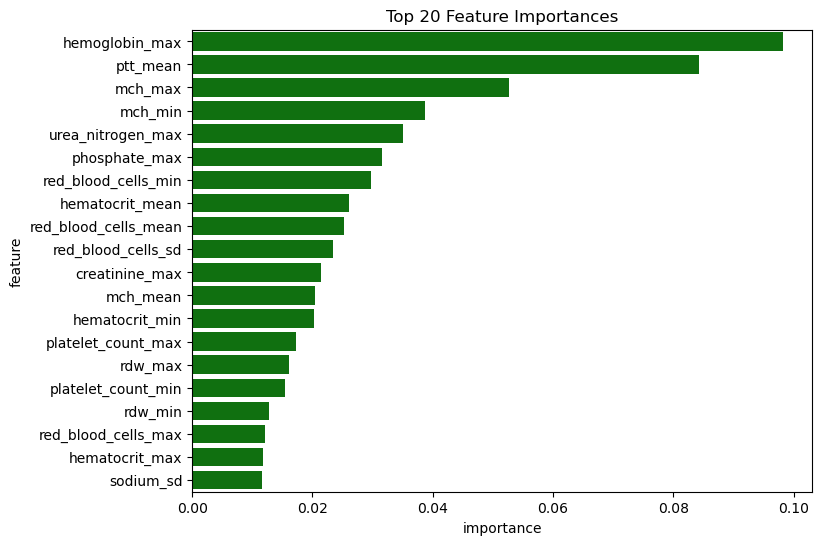

In [20]:
y_pred = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

np.savez(f'../results/tabnet_pretrained_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()